In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from DAX.HelpFunctions.get_dax_data import get_dax_data
import seaborn as sns


from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from HelpFunctions.date_and_time import most_recent_thursday
from HelpFunctions.date_and_time import next_working_days
from scipy.stats import norm
import math

In [ ]:
df = get_dax_data()

In [ ]:
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [ ]:
df.index = df.index.date

In [ ]:
from statsmodels.tsa.stattools import pacf

df_tmp = df
df_tmp['Date'] = pd.to_datetime(df_tmp.index)
df_tmp.set_index('Date', inplace=True)
df_tmp['ret1_sq'] = df_tmp['ret1']**2

# Calculate PACF for the ret1 column
lags = 20  # consider 5 lags
partial_autocorrelation = pacf(df_tmp['ret1_sq'].dropna(), nlags=5)

# Create PACF plot for the ret1 column
plt.figure(figsize=(10, 6))
plot_pacf(df_tmp['ret1_sq'].dropna(), lags=lags, title='Partial Autocorrelation Function (PACF) - ret1')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

It can be seen that the correlation of the lags is very high for the first lages. I'll therefore consider using GARCH(p,q) with a p,q>1.

## Create GARCH(1,1) model. Using normal distribution

In [ ]:
df_garch = df['ret1']
df_garch = df_garch.dropna()
len(df_garch)

In [ ]:
test_size = 900 # Take roughly 10% for testing
train, test = df_garch[:-test_size], df_garch[-test_size:]
model = arch_model(train, mean='zero', p=1, q=1)
model_fit = model.fit()

In [ ]:
model_fit.summary()

- aplha[1] and beta[1] are highly significant.
- (nu is ~8 so we have t(nu=8) best representing the data?) past results when using t-dist

### Predict using the GARCH(1,1) model

In [78]:
predictions = model_fit.forecast(horizon=1)

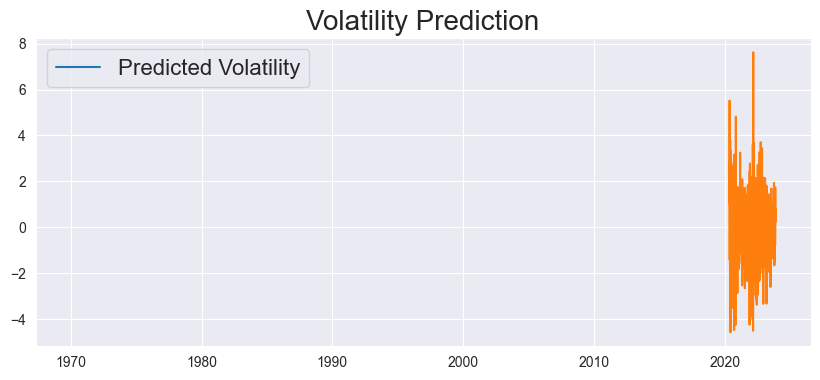

In [79]:
plt.figure(figsize=(10,4))
preds, = plt.plot(np.sqrt(predictions.variance.values[-1, :]))
true, = plt.plot(test[-test_size:])
plt.title('Volatility Prediction', fontsize=20)
plt.legend(['Predicted Volatility'], fontsize=16)

In [80]:
predictions.variance.values

array([[4.29786495]])

In [93]:
from scipy.stats import norm
import math
# Define the mean and standard deviation of the normal distribution
mean = 0
std_dev = 1
variance = predictions.variance.values[0][0]

# Calculate the quantile
predicted_quantiles = norm.ppf([0.025,0.25,0.5,0.75,0.975], loc=0, scale=math.sqrt(variance))

In [94]:
predicted_quantiles

array([-4.0632587 , -1.39830444,  0.        ,  1.39830444,  4.0632587 ])

### Now lets create one function that can run the whole thing.

In [4]:
df = get_dax_data()
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [5]:
df_cval = df_cval.dropna()

In [17]:


# from HelpFunctions.date_and_time import next_working_days


def get_norm_quantiles(variance):
        return norm.ppf([0.025,0.25,0.5,0.75,0.975], loc=0, scale=math.sqrt(variance))

# Runs GARCH(1,1) for each horizon
def garch11s(df):
    variances = [garch11(df[f'ret{h}'], h) for h in range(1,6)]
    quantiles = [get_norm_quantiles(v) for v in variances]
    column_names = [f'q{q}' for q in [0.025,0.25,0.5,0.75,0.975]]
    dates = next_working_days(max(df.index).date(), 5)
    
    
    quantile_df = pd.DataFrame(quantiles, columns=column_names)
    quantile_df['forecast_date'] = dates
    quantile_df.set_index('forecast_date', inplace=True)
    return quantile_df
        
        
    
# df should only contain one column (the log-returns of the horizon to predict)
def garch11(df, horizon):
    train = df.dropna()
    model = arch_model(train, mean='zero', p=1, q=1)
    model_fit = model.fit()
    predictions = model_fit.forecast(horizon=horizon)
    return predictions.variance.values[0][-1]

In [18]:
quantiles = garch11s(df)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 58589.12288077312
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17298.298708844035
Iteration:      3,   Func. Count:     21,   Neg. LLF: 25956.183934355784
Iteration:      4,   Func. Count:     27,   Neg. LLF: 14496.735137243277
Iteration:      5,   Func. Count:     32,   Neg. LLF: 14496.691566795726
Iteration:      6,   Func. Count:     35,   Neg. LLF: 14496.691566792215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14496.691566795726
            Iterations: 6
            Function evaluations: 35
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 61675.803841677916
Iteration:      2,   Func. Count:     14,   Neg. LLF: 21578.13731579131
Iteration:      3,   Func. Count:     20,   Neg. LLF: 19164.164398417197
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4916915484.65971
Iteration:      5,   Func. Count:     31,   Neg. LLF: 17382.383513